<a href="https://colab.research.google.com/github/jaltareyr/ITCS-6150-Project/blob/main/predict_diabetes_project_code_6150.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final project

## Project Title: Diabetes Prediction Using AI and Machine Learning Algorithms

Submitted By:::

Chetan Kapadia: 801438508

Sanjyot Sathe: 801426514

Mohan Krishna Otikunta: 801418781

Yashodhan Rajesh Jaltare: 801430080

Ravi Kumar 801304869


Dataset Reference:

Kaggle version: https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database

Gist
+2
PMC
+2

UCI (original) distribution: http://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data

perso.telecom-paristech.fr
+1

Citation:

Smith, J. W., Everhart, J. E., Dickson, W. C., Knowler, W. C., & Johannes, R. S. (1988). Using the ADAP learning algorithm to forecast the onset of diabetes mellitus. Proceedings of the Symposium on Computer Applications and Medical Care, 261–265. IEEE Computer Society Press.

Dataset Description:

This dataset contains medical diagnostic measurements for 768 female patients of Pima Indian heritage (age ≥ 21).
The goal is to predict whether a patient has diabetes (1) or not (0).

| Feature                      | Description                                                                          |
| ---------------------------- | ------------------------------------------------------------------------------------ |
| **Pregnancies**              | Number of times pregnant                                                             |
| **Glucose**                  | Plasma glucose concentration (mg/dL) after 2 hours in an oral glucose tolerance test |
| **BloodPressure**            | Diastolic blood pressure (mm Hg)                                                     |
| **SkinThickness**            | Triceps skin fold thickness (mm)                                                     |
| **Insulin**                  | 2-hour serum insulin (μU/mL)                                                         |
| **BMI**                      | Body mass index (weight in kg / (height in m)²)                                      |
| **DiabetesPedigreeFunction** | Genetic relationship measure (higher = stronger family history)                      |
| **Age**                      | Age in years                                                                         |
| **Outcome**                  | Diabetes diagnosis (1 = yes, 0 = no)                                                 |


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from joblib import dump


### Utilities


In [ ]:
def load_pima_diabetes_data(url: str, column_names: list) -> pd.DataFrame:
    """Loads the Pima Indians Diabetes dataset from a given URL."""
    try:
        df = pd.read_csv(url, names=column_names)
        print("Dataset loaded successfully.")
        return df
    except Exception as e:
        print(f"Failed to load dataset: {e}")
        return pd.DataFrame()  # Return empty DataFrame on failure


In [ ]:
def plot_diabetes_outcome_distribution(dataframe):
  # The bar chart shows how many people in our dataset have diabetes versus how many don’t.
  # It’s basically a quick way to visualize the balance between the two groups.

    """Plots the distribution of diabetes outcomes using a count plot."""
    plt.figure(figsize=(8, 5))
    sns.countplot(x='Outcome', hue='Outcome', data=dataframe, palette='Set2', legend=False)
    plt.title("Distribution of Diabetes Outcomes", fontsize=14)
    plt.xlabel("Outcome (0 = No Diabetes, 1 = Diabetes)", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.xticks([0, 1], ['No Diabetes', 'Diabetes'])
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_feature_correlation_heatmap(dataframe, figsize=(10, 8), cmap='coolwarm'):
    # heatmap that shows how different features (or columns) in a dataset are correlated with each other.
    # A heatmap is a visual representation of data where individual values are represented by colors.
    # In this case, it helps us see the strength of relationships between the columns.

    """Plots a heatmap showing feature correlations in the given DataFrame."""
    correlation_matrix = dataframe.corr()

    #plt.figure(figsize=figsize)
    plt.figure(figsize=figsize)
    sns.heatmap(correlation_matrix, annot=True, cmap=cmap, fmt=".2f", linewidths=0.5, square=True)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    #plt.show()
    plt.show()


In [ ]:
def plot_pairwise_feature_relationships(dataframe, features, hue='Outcome', diag_kind='kde', title="Pairwise Feature Relationships"):
    # a pairwise plot that visualizes how multiple features in your dataset relate to each other.
    # It uses Seaborn's pairplot, which is a great way to explore relationships between pairs of features in a dataset.

    """Plots pairwise relationships among selected features using Seaborn's pairplot."""
    sns.set(style="whitegrid")
    pairplot = sns.pairplot(dataframe[features], hue=hue, diag_kind=diag_kind, palette='Set2')
    pairplot.fig.suptitle(title, y=1.02, fontsize=14)
    plt.show()



In [ ]:
def plot_age_vs_glucose(dataframe, x='Age', y='Glucose', hue='Outcome', palette='coolwarm', figsize=(10, 6)):
    """Plots a scatter plot of Age vs Glucose, colored by diabetes outcome."""
    plt.figure(figsize=figsize)
    sns.scatterplot(x=x, y=y, hue=hue, data=dataframe, palette=palette)
    plt.title("Age vs Glucose (Colored by Diabetes Outcome)", fontsize=14)
    plt.xlabel(x, fontsize=12)
    plt.ylabel(y, fontsize=12)
    plt.legend(title=hue)
    plt.tight_layout()
    plt.show()


In [ ]:
# prepare_data_for_modeling function as our data prep assistant before building a machine learning model.

# It takes our raw dataset and gets it ready for training by:

# Splitting it into training and testing sets.

# Scaling the features so they’re all on the same playing field.

def prepare_data_for_modeling(dataframe, target_column='Outcome', test_size=0.2, random_state=42):
    """
    Splits the dataset into training and testing sets, and standardizes the features.

    Parameters:
        dataframe (pd.DataFrame): The input dataset.
        target_column (str): The name of the target column.
        test_size (float): Proportion of the dataset to include in the test split.
        random_state (int): Seed for reproducibility.

    Returns:
        X_train_scaled, X_test_scaled, y_train, y_test
    """
    # Separate features and target
    #X: the input features (like age, glucose, BMI…)
    #y: the target we want to predict (in this case, whether someone has diabetes)
    X = dataframe.drop(columns=[target_column])
    y = dataframe[target_column]

    # Split into training and testing sets
    # Training set (80%): used to teach the model
    # Testing set (20%): used to see how well the model performs
    # The stratify=y part makes sure both sets have a balanced mix of diabetic and non-diabetic cases.
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    # Standardize features
    # It standardizes the features so they all have the same scale —
    # this is super important for models like KNN that rely on distances between points.
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return scaler, X_train_scaled, X_test_scaled, y_train, y_test

In [ ]:
def evaluate_knn(X_train, y_train, X_test, y_test, max_k=20):

    # Imagine a teacher grading students
    # We’ve got a group of students (your KNN models), and each one tries a different strategy:
    # Student 1 looks at 1 neighbor to make decisions.
    # Student 2 looks at 2 neighbors.
    # … all the way up to Student 20.
    # Each student takes the test (predicts on our test data), and we give them a score (accuracy).

    # Lineup the students: It creates models with different k values (number of neighbors).
    # Test them one by one: Each model predicts the test answers, and we measure how many they got right.
    # Keep track of scores: All the accuracy scores are stored neatly in a list.
    # Draw a chart: It plots the scores so we can see which student (k value) did best.
    # Announce the winner: Finally, it prints the best k — the one with the highest accuracy.

    """Evaluate KNN accuracy for k=1..max_k and return scores + best k."""
    k_values = range(1, max_k + 1)
    scores = [
        accuracy_score(y_test, KNeighborsClassifier(n_neighbors=k)
                       .fit(X_train, y_train)
                       .predict(X_test))
        for k in k_values
    ]

    # Plot results
    plt.figure(figsize=(8, 5))
    plt.plot(k_values, scores, marker='o')
    plt.xlabel('Number of Neighbors (k)')
    plt.ylabel('Accuracy')
    plt.title('KNN Accuracy for Different k Values')
    plt.grid(True)
    plt.show()

    # Best k
    best_k = k_values[scores.index(max(scores))]
    print(f"Best k value: {best_k} (Accuracy: {max(scores):.4f})")
    return scores, best_k

In [ ]:
#train_knn_classifier function is like our personal coach for building a K-Nearest Neighbors (KNN) model.
#It takes our training data and teaches the model how to recognize patterns
#— so later, it can predict whether someone has diabetes based on their health features.

def train_knn_classifier(X_train, y_train, n_neighbors=5):
    """
    Trains a K-Nearest Neighbors classifier on the provided training data.

    Parameters:
        X_train (array-like): Scaled training features.
        y_train (array-like): Training labels.
        n_neighbors (int): Number of neighbors to use (default is 5).

    Returns:
        knn (KNeighborsClassifier): Trained KNN model.
    """

    #X_train: This is our input data — things like glucose level, age, BMI, etc.
    #y_train: These are the correct answers — whether each person has diabetes (1) or not (0).
    #n_neighbors=5: This tells the model to look at the 5 closest neighbors when making a prediction.
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    #knn.fit(X_train, y_train)
    knn.fit(X_train, y_train)
    return knn

In [ ]:
# make_knn_predictions function is like your KNN model’s crystal ball —
# it uses the trained model to make predictions on new data. It tells us:

# Who it thinks has diabetes (based on the test data)

# How confident it is in those predictions

def make_predictions(model, X_test):
    """
    Generates predictions and probability scores using a trained KNN model.

    Parameters:
        model (KNeighborsClassifier) / Logistic Regression / Random Forest: Trained model.
        X_test (array-like): Scaled test features.

    Returns:
        y_pred (array): Predicted class labels.
        y_prob (array): Predicted probabilities for the positive class (used for ROC-AUC).
    """

    #This predict function asks the model to predict the outcome (diabetes or not)
    #for each person in the test set.
    #We get a list of 0s and 1s — 0 means no diabetes, 1 means diabetes.
    y_pred = model.predict(X_test)

    #predict_proba function gives us the probability that each person has diabetes.
    #It’s useful when we want to measure how confident the model is — especially for metrics like ROC-AUC.
    y_prob = model.predict_proba(X_test)[:, 1]  # Probability of class 1 (diabetes)

    return y_pred, y_prob


In [ ]:
#train_logistic_regression Takes in training data (X_train, y_train).

# Builds a Logistic Regression model with safe defaults (like more iterations so it doesn’t quit too early).

# Fits the model so it learns patterns from our data.

# Returns the trained model so we can use it later to predict outcomes or check accuracy.

def train_logistic_regression(X_train, y_train, max_iter=1000, random_state=42):
    """Train a Logistic Regression model with scaling already applied."""
    model = LogisticRegression(max_iter=max_iter, random_state=random_state)
    model.fit(X_train, y_train)
    return model

In [ ]:
# train_random_forest is our shortcut to grow a forest of decision trees,
# train them on our data, and get a strong, reliable model back.

def train_random_forest(X_train, y_train, n_estimators=100, random_state=42, max_depth=None):
    """
    Train a Random Forest classifier.

    Parameters:
        X_train (array-like): Training features (already scaled if needed)
        y_train (array-like): Training labels
        n_estimators (int): Number of trees in the forest
        random_state (int): Seed for reproducibility
        max_depth (int or None): Maximum depth of the trees

    Returns:
        model: Trained RandomForestClassifier
    """
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        random_state=random_state,
        max_depth=max_depth
    )
    model.fit(X_train, y_train)
    return model


In [ ]:
#evaluate_model_performance function is like our model’s report card.
#After our model makes predictions,
#this function checks how well it did —
#using five key metrics that tell us if our model is smart, fair, and reliable.

#It gives us a quick snapshot of your model’s performance.

#We can compare models easily using the same metrics.

#It helps us spot weaknesses — like if your model misses too many real cases (low recall).

def evaluate_model_performance(y_true, y_pred, y_prob):
    """
    Evaluates and prints key classification metrics for a model.

    Parameters:
        y_true (array-like): True labels.
        y_pred (array-like): Predicted labels.
        y_prob (array-like): Predicted probabilities for the positive class.
    """

  #Accuracy: How often the model got it right overall.

  #Precision: When it said “diabetes,” how often was it correct?

  #Recall: Out of all actual diabetes cases, how many did it catch?

  #F1-score: A balance between precision and recall — great for uneven datasets.

  #ROC-AUC: Measures how well the model separates diabetic vs non-diabetic cases using probability scores.

    metrics = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-score": f1_score(y_true, y_pred),
        "ROC-AUC": roc_auc_score(y_true, y_prob)
    }

    for name, value in metrics.items():
        print(f"{name}: {value:.3f}")




In [ ]:
# display_classification_report function is like our model’s performance summary sheet.
# After our model makes predictions, it prints out a detailed report showing how well it did —
# not just overall, but for each class (like diabetic vs non-diabetic).
def display_classification_report(y_true, y_pred, target_names=None):
    """
    Prints a formatted classification report showing precision, recall, f1-score, and support.

    Parameters:
        y_true (array-like): True labels.
        y_pred (array-like): Predicted labels.
        target_names (list, optional): Names for target classes (e.g., ['No Diabetes', 'Diabetes']).
    """

    # This generates and prints a table that shows:

    # Precision: How often the model was right when it predicted a class.

    # Recall: How many actual cases the model correctly identified.

    # F1-score: A balance between precision and recall.

    # Support: How many examples were in each class.

    # If we provide target_names, it replaces the default 0/1 labels
    # with something more readable like “No Diabetes” and “Diabetes.”
    print("\n📋 Classification Report:\n")
    report = classification_report(y_true, y_pred, target_names=target_names)
    print(report)


In [ ]:
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix - KNN Classifier", cmap='Blues'):

    # confusion matrix heatmap, which is a handy way to see how well a classification model (like a KNN classifier) is performing.
    # A confusion matrix basically compares what your model predicted versus what the actual answers were — and shows the results in a simple grid.

    """
    Plots a heatmap of the confusion matrix for classification results.

    Parameters:
        y_true (array-like): True labels.
        y_pred (array-like): Predicted labels.
        title (str): Title of the plot.
        cmap (str): Color map for the heatmap.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, cbar=False)
    plt.title(title, fontsize=14)
    plt.xlabel("Predicted", fontsize=12)
    plt.ylabel("Actual", fontsize=12)
    plt.tight_layout()
    plt.show()



## Load data and preprocessing

In [ ]:
# Define dataset URL and column names
DATA_URL = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
COLUMN_NAMES = [
    'Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
    'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'
]



In [ ]:
# Load the dataset
df = load_pima_diabetes_data(DATA_URL, COLUMN_NAMES)

print(df.head())

Dataset loaded successfully.
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


In [ ]:
print(df.describe())
print(df['Outcome'].value_counts())


       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  

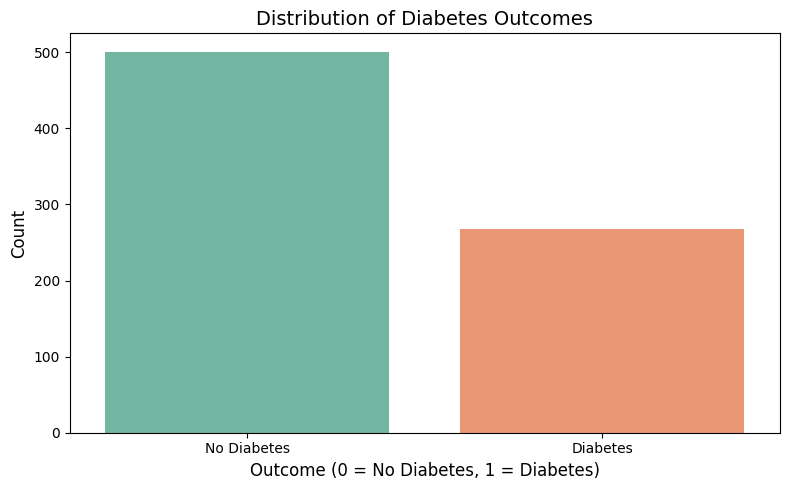

In [ ]:
plot_diabetes_outcome_distribution(df)

# Feature Correlation Heatmap
graph helps us identify features that might be unnecessary or closely connected.
It also assists with feature engineering and model tuning.
Plus, it makes your data exploration more intuitive and visually appealing.


Dark red = strong positive correlation (close to +1)

Dark blue = strong negative correlation (close to –1)

White/light colors = weak or no correlation (close to 0)

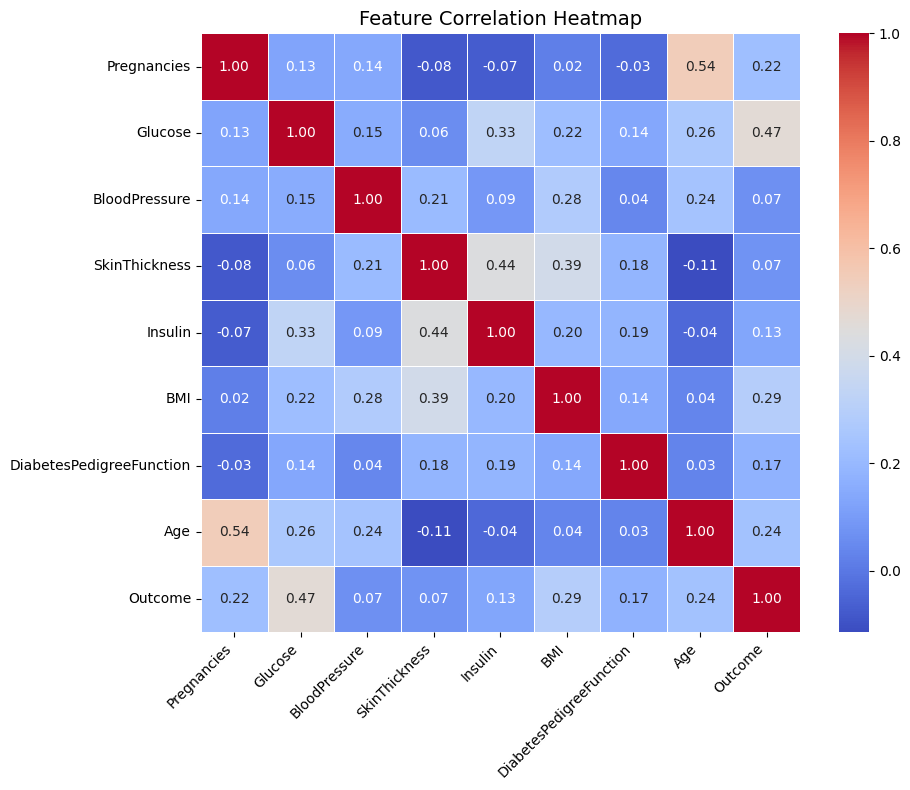

In [ ]:
plot_feature_correlation_heatmap(df)

#Pairwise Feature Relationships
graph is a grid of scatter plots and histograms — to help us explore how different features in our dataset relate to each other. It’s like speed dating for our data: every feature gets a chance to meet every other feature and show how they interact!

We can spot patterns — like whether higher glucose levels are linked to diabetes.

We can see clusters or overlaps between groups.

It’s a great way to visually explore our data before building models.

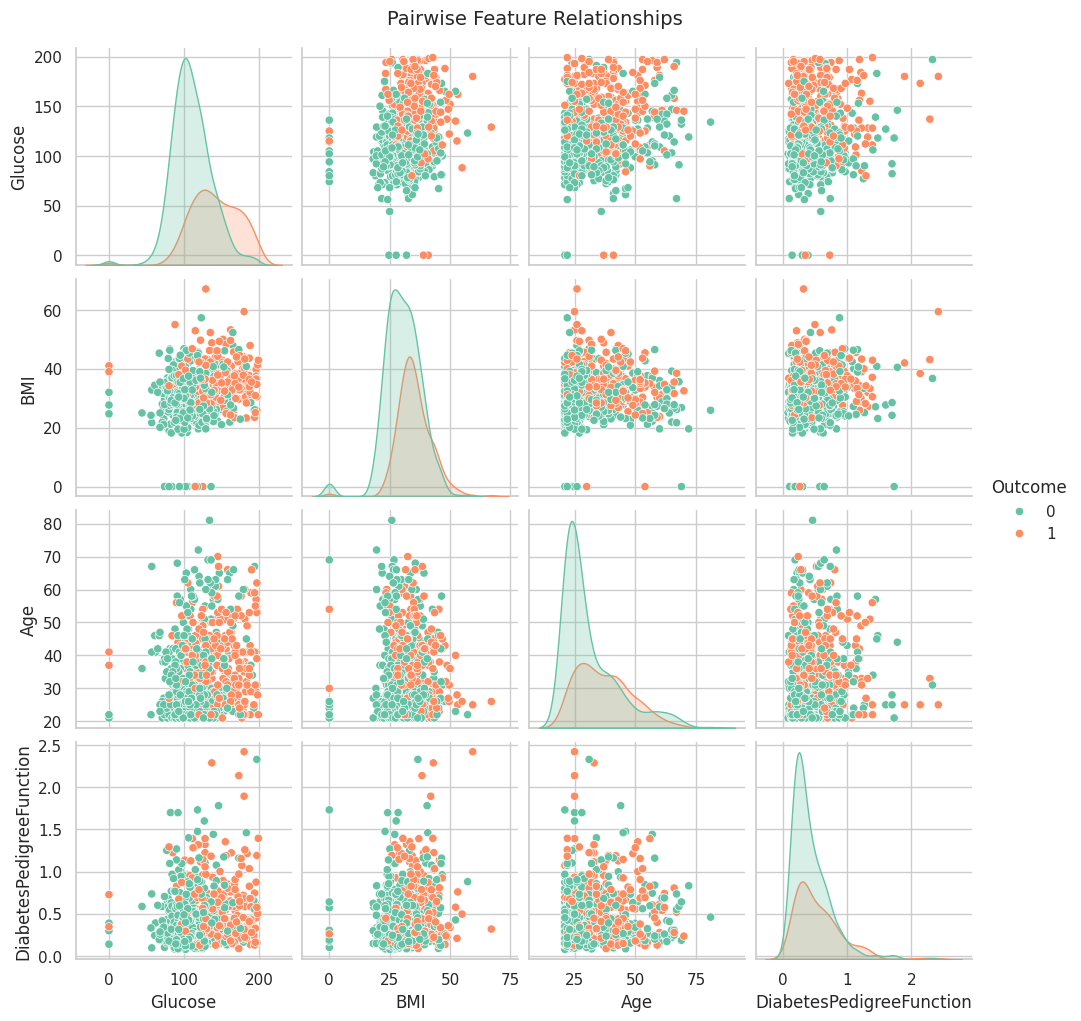

In [ ]:
# Define features to include
selected_features = ['Glucose', 'BMI', 'Age', 'DiabetesPedigreeFunction', 'Outcome']

# Call the function
plot_pairwise_feature_relationships(df, selected_features)

#Scatter Plot: Age vs Glucose
graph Tshows how a person’s age relates to their glucose level — and it adds a splash of color to show whether or not they have diabetes. It’s like putting our data on a map and using color to highlight patterns.

It’s a quick way to visualize relationships in our data.

We can spot clusters or outliers.

It helps us to understand patterns before building a predictive model.

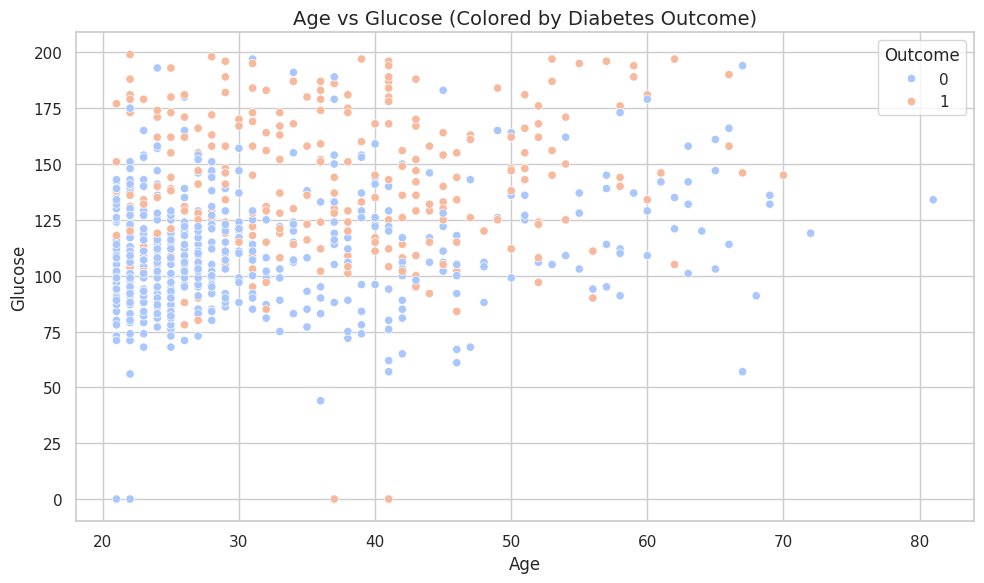

In [ ]:
plot_age_vs_glucose(df)

## KNN - build model, train&test, performance

In [ ]:
scaler, X_train_scaled, X_test_scaled, y_train, y_test = prepare_data_for_modeling(df)

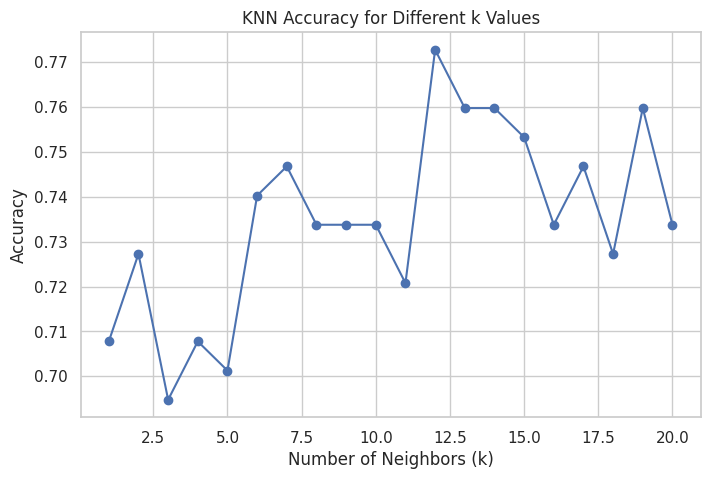

Best k value: 12 (Accuracy: 0.7727)


In [ ]:
scores, best_k = evaluate_knn(X_train_scaled, y_train, X_test_scaled, y_test)

In [ ]:
knn_model = train_knn_classifier(X_train_scaled, y_train,best_k)

In [ ]:
dump(knn_model, 'diabetes_knn_model.joblib')

['diabetes_knn_model.joblib']

In [ ]:
y_pred, y_prob = make_predictions(knn_model, X_test_scaled)

In [ ]:
evaluate_model_performance(y_test, y_pred, y_prob)

Accuracy: 0.773
Precision: 0.721
Recall: 0.574
F1-score: 0.639
ROC-AUC: 0.782


In [ ]:
display_classification_report(y_test, y_pred, target_names=['No Diabetes', 'Diabetes'])


📋 Classification Report:

              precision    recall  f1-score   support

 No Diabetes       0.79      0.88      0.83       100
    Diabetes       0.72      0.57      0.64        54

    accuracy                           0.77       154
   macro avg       0.76      0.73      0.74       154
weighted avg       0.77      0.77      0.77       154



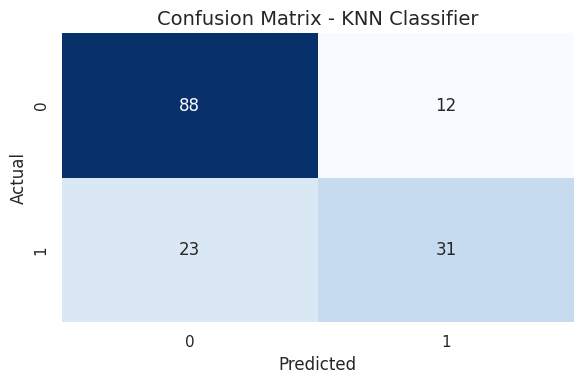

In [ ]:
plot_confusion_matrix(y_test, y_pred)

## Regression Logistic Classifier - build model, train&test, performance

In [ ]:
logistic_regression_model = train_logistic_regression(X_train_scaled, y_train)

In [ ]:
y_pred, y_prob = make_predictions(logistic_regression_model, X_test_scaled)

In [ ]:
evaluate_model_performance(y_test, y_pred, y_prob)

Accuracy: 0.714
Precision: 0.609
Recall: 0.519
F1-score: 0.560
ROC-AUC: 0.823


In [ ]:
display_classification_report(y_test, y_pred, target_names=['No Diabetes', 'Diabetes'])


📋 Classification Report:

              precision    recall  f1-score   support

 No Diabetes       0.76      0.82      0.79       100
    Diabetes       0.61      0.52      0.56        54

    accuracy                           0.71       154
   macro avg       0.68      0.67      0.67       154
weighted avg       0.71      0.71      0.71       154



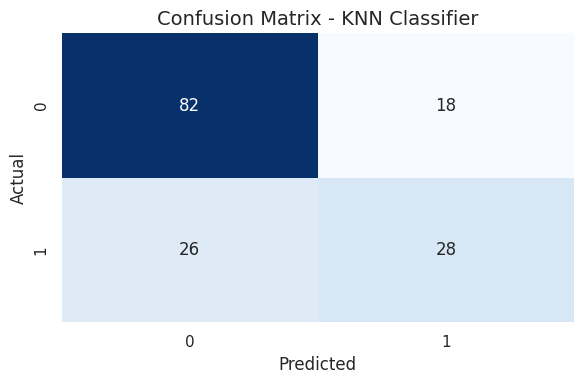

In [ ]:
plot_confusion_matrix(y_test, y_pred,title="Confusion Matrix - Regression Logistic Classifier")

## Random Forest - build model, train&test, performance


In [ ]:
rf_model = train_random_forest(X_train_scaled, y_train)

In [ ]:
y_pred, y_prob = make_predictions(rf_model, X_test_scaled)

In [ ]:
evaluate_model_performance(y_test, y_pred, y_prob)

Accuracy: 0.760
Precision: 0.681
Recall: 0.593
F1-score: 0.634
ROC-AUC: 0.815


In [ ]:
display_classification_report(y_test, y_pred, target_names=['No Diabetes', 'Diabetes'])


📋 Classification Report:

              precision    recall  f1-score   support

 No Diabetes       0.79      0.85      0.82       100
    Diabetes       0.68      0.59      0.63        54

    accuracy                           0.76       154
   macro avg       0.74      0.72      0.73       154
weighted avg       0.75      0.76      0.76       154



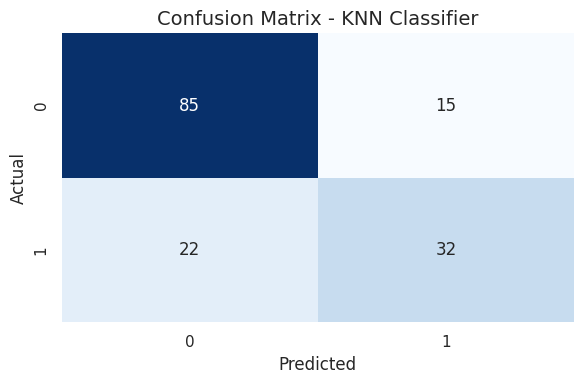

In [ ]:
plot_confusion_matrix(y_test, y_pred,title="Confusion Matrix - Random Forest")

In [ ]:
# Input feature names (must match the training DataFrame!)
feature_names = [
    "Pregnancies", "Glucose", "BloodPressure", "SkinThickness",
    "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"
]

# User input
user_data = np.array([[2, 120, 70, 25, 100, 28.0, 0.35, 29]])
# user_data = np.array([[6, 148, 72, 35, 0, 33.6, 0.627, 50]]) // diabetes positive

# Convert to DataFrame with correct column names
user_df = pd.DataFrame(user_data, columns=feature_names)

# Scale using the SAME trained scaler
user_data_scaled = scaler.transform(user_df)

# Predict
prediction = knn_model.predict(user_data_scaled)

# Interpret result
if prediction[0] == 1:
    print("🔴 The KNN model predicts: Diabetic")
else:
    print("🟢 The KNN model predicts: Not Diabetic")

# Predict
prediction = logistic_regression_model.predict(user_data_scaled)

# Interpret result
if prediction[0] == 1:
    print("🔴 The Logistic Regression model predicts: Diabetic")
else:
    print("🟢 The Logistic Regression model predicts: Not Diabetic")

# Predict
prediction = rf_model.predict(user_data_scaled)

# Interpret result
if prediction[0] == 1:
    print("🔴 The Random Forest model predicts: Diabetic")
else:
    print("🟢 The Random Forest model predicts: Not Diabetic")

🟢 The KNN model predicts: Not Diabetic
🟢 The Logistic Regression model predicts: Not Diabetic
🟢 The Random Forest model predicts: Not Diabetic
